In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
sys.path.append("..")
sys.path.append("../InverseProblem/inverse_scripts/")
import inverse_gnn
import utils
import torch
from glob import glob
import modules
import gnn_module
import dataio
from functools import partial

device = "cuda:0"

### config

In [3]:
data_file = "../data/data/coarse_valid"
path_to_data = "../data/"
loss_fn = "l2"
time_steps = [30]
sensor_num = 20
start_observation_index = 2
obversation_step = 2
num_iter = 500

progressive = False
repeat_time = 100

edge_features = ['dist','direction']
node_features=('u', 'v', 'density', 'type')

### load solver

In [4]:
solver_path = os.path.join(path_to_data,"model_zoo/gnn_solver_3136000.pth")
gnn_solver = gnn_module.mesh_PDE(edge_dim=3,node_dim=4, latent_dim = 256,num_steps=10,layer_norm=True,
                                nl='relu',var=0,batch_norm=False,normalize=True,encoder_nl='relu',
                                diffMLP=True).to(device)
checkpoint_gnn = torch.load(solver_path,map_location=device)
gnn_solver.load_state_dict(checkpoint_gnn['model_state_dict'])
graph_update_fn = partial(dataio.wave_data_update,('u', 'v', 'density','type'))

### load prior

In [5]:
prior = modules.CoordinateNet_autodecoder(latent_size=64, nl='relu', in_features=64+2, out_features=1,
                                hidden_features=256,
                                num_hidden_layers=6, num_pe_fns=3,
                                w0=60,use_pe=True,skip_connect=None,dataset_size=10000,
                                outmost_nonlinearity="sigmoid",outermost_linear=False).to(device)

prior_path = os.path.join(path_to_data,"model_zoo/prior_field.pth")
checkpoint_prior = torch.load(prior_path,map_location=device)
prior.load_state_dict(checkpoint_prior)
prior.lat_vecs = None

### inverse problem without prior

Solving linear variational problem.
No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 3.845e-02 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 2.827e-05 (tol = 1.000e-10) r (rel) = 7.351e-04 (tol = 1.000e-09)
  Newton iteration 2: r (abs) = 2.283e-09 (tol = 1.000e-10) r (rel) = 5.938e-08 (tol = 1.000e-09)
  Newton iteration 3: r (abs) = 3.337e-17 (tol = 1.000e-10) r (rel) = 8.679e-16 (tol = 1.000e-09)
  Newton solver finished in 3 iterations and 3 linear solver iterations.
steps [30 30 30 30 30]
iter: 0
loss:0.012517157942056656
mse:0.04937445744872093


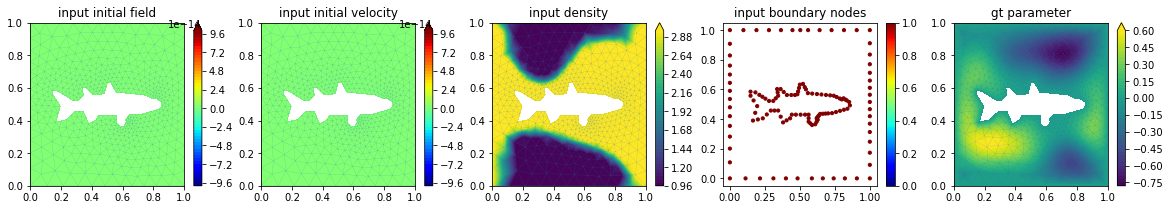

 iter:  499
 masked:0.036101084202528 
loss:5.1464507123455405e-05 
mse:0.017062846571207047 


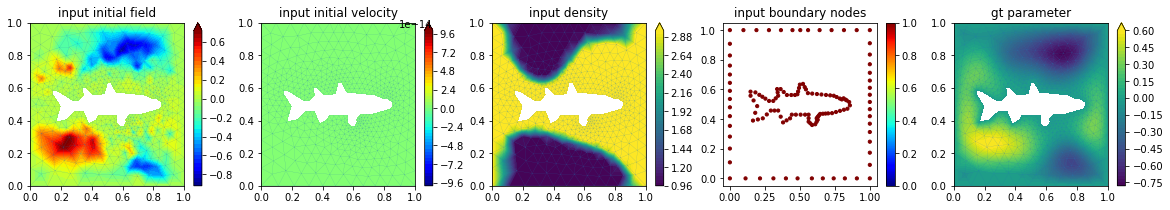

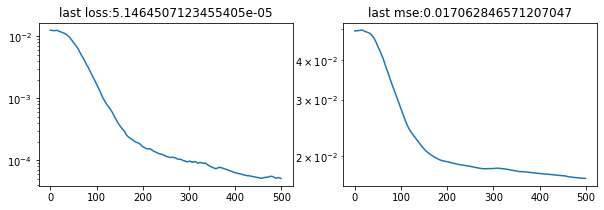

In [6]:
lr = 0.01
lr_decay = 1
lr_decay_steps = 1000
reg = 0
resolution = 64 ##?
log_path = "./log/init_state/"
store = True
mse_vs_time = os.path.join(log_path, "mse_vs_time")
run_time = os.path.join(log_path, "run_time")
individual_npy = os.path.join(log_path, "individual_npy")
gradient_norms = os.path.join(log_path, "gradient_norms")

utils.cond_mkdir(log_path)
utils.cond_mkdir(mse_vs_time)
utils.cond_mkdir(run_time)
utils.cond_mkdir(individual_npy)
utils.cond_mkdir(gradient_norms)


noprior = False
prior_type = "init_state"
gradient_clip = 0.01

inverse_gnn.test_inverse(start_index=0,dataset_size=1,prior=prior,gnn_solver=gnn_solver,
                         graph_update_fn=graph_update_fn,time_steps=time_steps,
                        sensor_num=sensor_num,num_iter=num_iter,lr=lr,lr_decay=lr_decay,lr_decay_steps=lr_decay_steps,
                         resolution=resolution,log_path=log_path,store=store,data_file=data_file,
                         edge_features=edge_features,prior_type=prior_type,
                        noprior = True,loss_fn=loss_fn, progressive=progressive, repeat_time=repeat_time,
                         convergence_stop=True,path_to_data=path_to_data,obversation_step= obversation_step,
                         start_observation_index=start_observation_index,mask_type="random_nodes",
                         gradient_clip=gradient_clip,lr_decay_type="per_iter",reg=reg,device=device)


### inverse problem with prior

Solving linear variational problem.
No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 3.845e-02 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 2.827e-05 (tol = 1.000e-10) r (rel) = 7.351e-04 (tol = 1.000e-09)
  Newton iteration 2: r (abs) = 2.283e-09 (tol = 1.000e-10) r (rel) = 5.938e-08 (tol = 1.000e-09)
  Newton iteration 3: r (abs) = 3.337e-17 (tol = 1.000e-10) r (rel) = 8.679e-16 (tol = 1.000e-09)
  Newton solver finished in 3 iterations and 3 linear solver iterations.
steps [30 30 30 30 30]
iter: 0
loss:0.005590838845819235
mse:0.03789220005273819


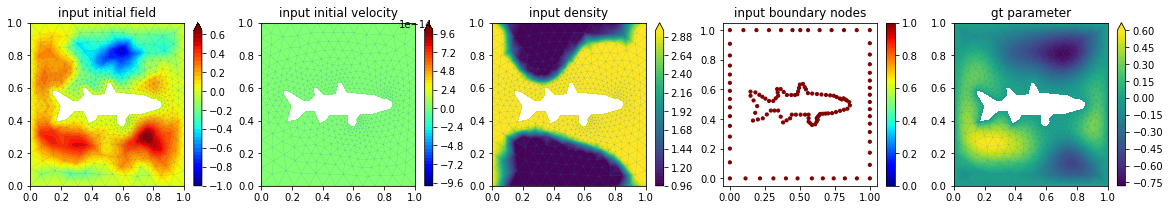

 iter:  499
 masked:0.036101084202528 
loss:3.118332097074017e-05 
mse:0.0015226892428472638 


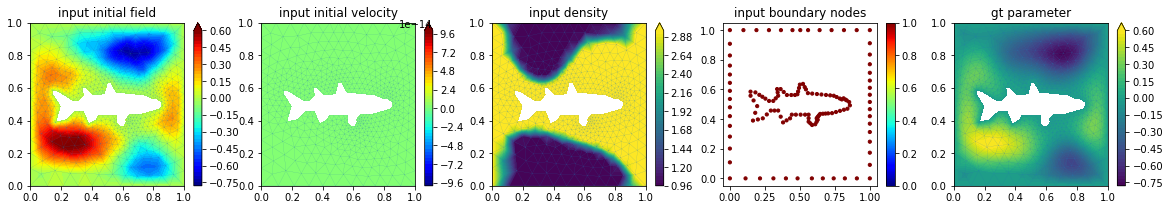

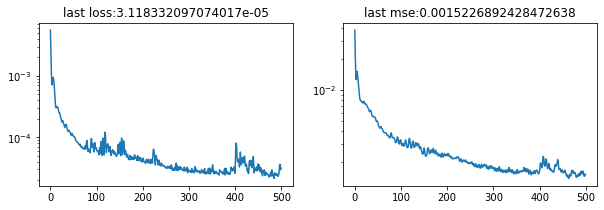

In [7]:
lr = 0.001
lr_decay = 0.1
lr_decay_steps = 1000
reg = 0
resolution = 64 ##?
log_path = "./log/init_state/"
store = True

noprior = False
prior_type = "init_state"
gradient_clip = 0.01

inverse_gnn.test_inverse(start_index=0,dataset_size=1,prior=prior,gnn_solver=gnn_solver,
                         graph_update_fn=graph_update_fn,time_steps=time_steps,
                        sensor_num=sensor_num,num_iter=num_iter,lr=lr,lr_decay=lr_decay,lr_decay_steps=lr_decay_steps,
                         resolution=resolution,log_path=log_path,store=store,data_file=data_file,
                         edge_features=edge_features,prior_type=prior_type,
                        noprior = noprior,loss_fn=loss_fn, progressive=progressive, repeat_time=repeat_time,
                         convergence_stop=True,path_to_data=path_to_data,obversation_step= obversation_step,
                         start_observation_index=start_observation_index,mask_type="random_nodes",
                         gradient_clip=gradient_clip,lr_decay_type="per_iter",reg=reg,device=device)
